# **Задание**

Цель: Изучить применение методов по поиску выбросов в данных, попрактиковаться в обработке экстремальных значений.

Описание задания:
В домашнем задании нужно решить задачу классификации типа стекол. Данные для обучения моделей можно скачать с сайта. Целевая переменная – тип стекла «Type». Остальные признаки описывают химические элементы в составе материала. Датасет нужно исследовать на наличие выбросов, провести EDA.

Этапы работы:

1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

2. Проведите первичный анализ.
    - а) Проверьте количество записей для каждого класса. Сделайте вывод.

3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

4. Обучите модель дерева решений RandomForestClassifier на обучающем множестве.

5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

6. Обработайте выбросы в данных.
    - а) Визуализируйте распределение значений для каждой переменной. Можно использовать функции sns.boxplot, sns.distplot. Есть ли признаки с нормальным распределением?
    - b) Исследуйте признаки на выбросы несколькими способами.
    - c) Удалите выбросы. *Посчитайте процент удаленных записей от общего числа записей для каждого класса.
    
7. Повторите п. 4, п. 5.

8. Сформулируйте выводы по проделанной работе.
    - а) Кратко опишите, какие преобразования были сделаны с данными.
    - b) Сравните точность двух моделей.
    - c) Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

Для получения зачета по этому домашнему заданию минимально должны быть реализованы методы по поиску выбросов и построены две модели: «до» и «после» обработки экстремальных значений.

Результат:
Получены практические знания по работе с выбросами в данных.

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
# Инициализация пустого df для накопления метрик
df_score = pd.DataFrame()


# Функция обучения модели и вывода report
def fit_and_report(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_model = model.predict(X_test)
    report = classification_report(y_test, y_pred_model, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df


# Функция добавления метрик в df_score
def df_score_append(df_score, report, model_name):
    weighted_avg = report.loc["weighted avg"]
    df_score = pd.concat(
        [df_score, pd.DataFrame(weighted_avg).transpose().assign(model=model_name)]
    )
    return df_score


# 1. Получите данные и загрузите их в рабочую среду

In [57]:
df = pd.read_csv("./glass.csv")
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


# 2. Проведите первичный анализ.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [59]:
df["Type"].value_counts()

Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

65% всего объема данных занимают 1 и 2 классы

Type of glass: (class attribute)

-- 1 building_windows_float_processed

-- 2 building_windows_non_float_processed

-- 3 vehicle_windows_float_processed

-- 4 vehicle_windows_non_float_processed (none in this database)

-- 5 containers

-- 6 tableware

-- 7 headlamps


# 3. Разделите выборку на обучающее и тестовое подмножество.

In [60]:
X = df.drop(["Type"], axis=1)
y = df["Type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 4. Обучите модель дерева решений RandomForestClassifier на обучающем множестве.

In [61]:
# Обучение
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

In [62]:
predictions = rf.predict(X_test)
rf.score(X_train, y_train), rf.score(X_test, y_test)

(1.0, 0.8372093023255814)

- Модель переобучилась, но точность предсказаний на тестовых данных при этом все же высокая

#  6. Обработайте выбросы в данных.\

# - а) Визуализируйте распределение значений для каждой переменной.

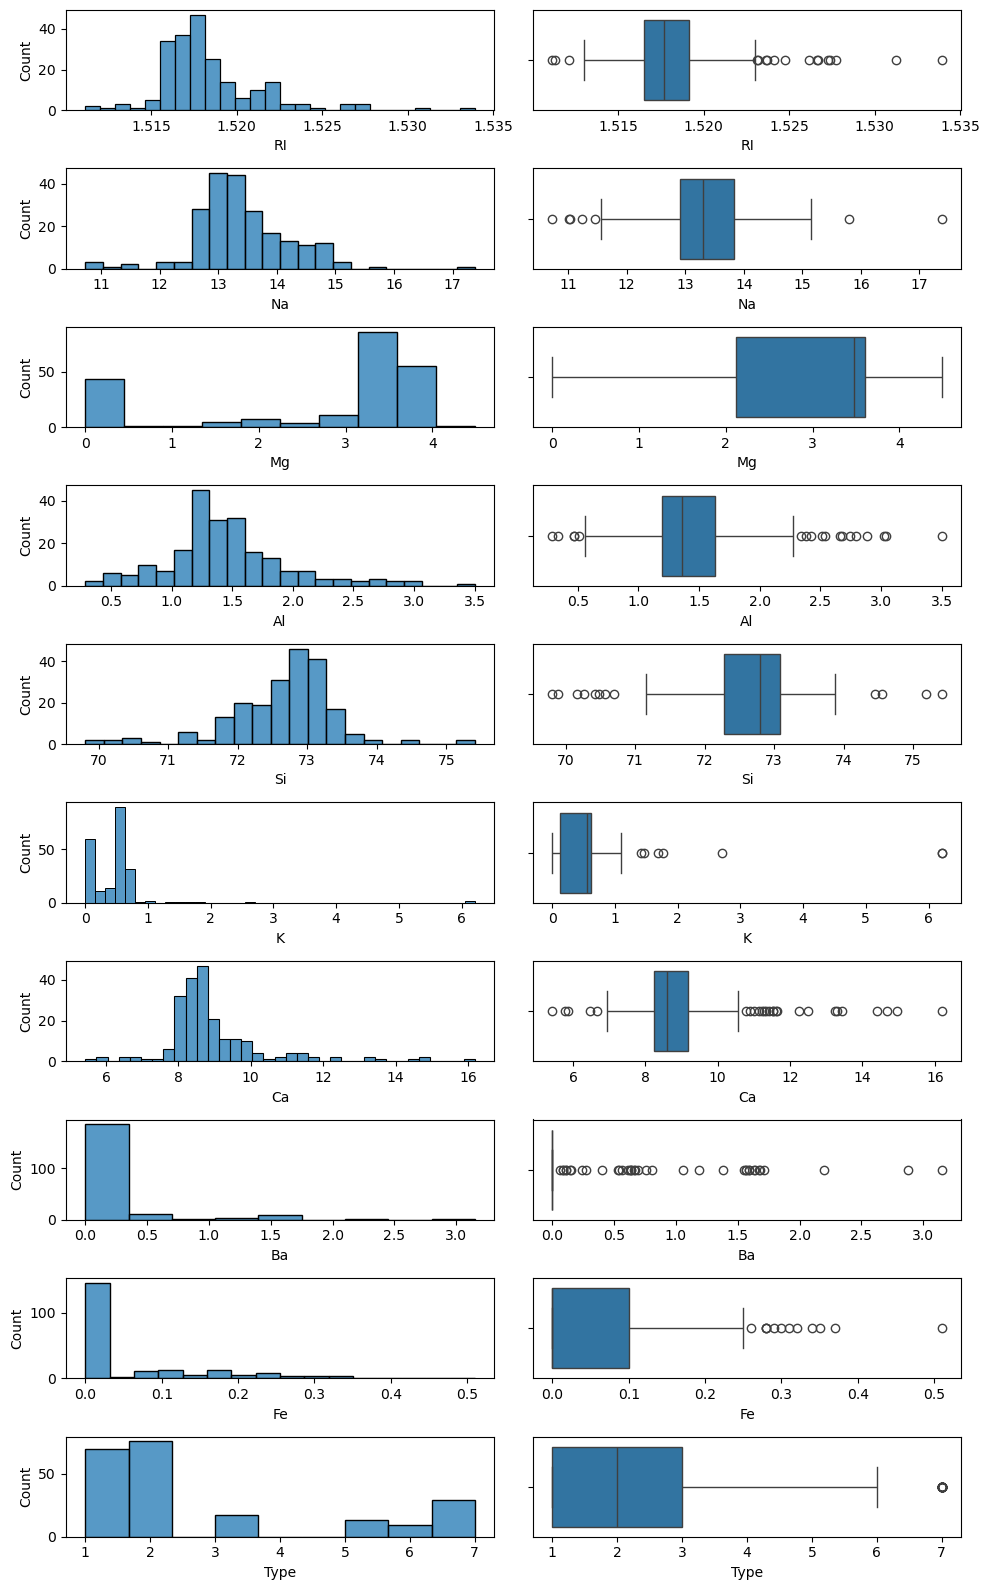

In [63]:
fig, ax = plt.subplots(10, 2, figsize=(10, 16))

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=ax[i][0])
    sns.boxplot(df[col], ax=ax[i][1], orient="h")
    plt.tight_layout()


Практически у всех признаков (RI, Na, Al, K, Ca, Ba, Fe) на boxplot'ах видны точки за пределами "усов", что указывает на наличие выбросов. Особенно много их у K, Ca, Ba.

# - b) Исследуйте признаки на выбросы несколькими способами.

In [64]:
df_clear = df.copy()

for i, col in enumerate(df.columns):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    l = q1 - 1.5 * iqr
    r = q3 + 1.5 * iqr

    df_clear = df_clear.loc[df[col].between(l, r)]

df_outlier = pd.concat([df, df_clear]).drop_duplicates(keep=False)

In [65]:
print(
    f"Строк с выбросами: {len(df_outlier)} ({round(100 * len(df_outlier) / len(df), 1)}% всех данных)."
)

Строк с выбросами: 76 (35.5% всех данных).


## Методы - IsolationForest, OneClassSVM, EllipticEnvelope, LocalOutlierFactor, DBSCAN

In [66]:
def detect_outliers_with_models(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    models = {
        "IsolationForest": IsolationForest(contamination=0.1, random_state=42),
        "OneClassSVM": OneClassSVM(nu=0.1),
        "EllipticEnvelope": EllipticEnvelope(
            support_fraction=0.7, contamination=0.1, random_state=42
        ),
        "LocalOutlierFactor": LocalOutlierFactor(contamination=0.1),
        "DBSCAN": DBSCAN(eps=2, min_samples=10),
    }

    results_list = []

    for name, model in models.items():
        y_pred = model.fit_predict(X_scaled)

        n_outliers = np.sum(y_pred == -1)
        total_samples = len(y_pred)
        percent_outliers = (n_outliers / total_samples) * 100

        results_list.append(
            {
                "Model": name,
                "Removed": n_outliers,
                "% Removed": f"{percent_outliers:.2f}%",
            }
        )

    results_df = pd.DataFrame(results_list)
    return results_df.set_index("Model")


df_outlier_model = detect_outliers_with_models(X)

df_outlier_model


,Removed,% Removed
Model,,
IsolationForest,22,10.28%
OneClassSVM,18,8.41%
EllipticEnvelope,22,10.28%
LocalOutlierFactor,22,10.28%
DBSCAN,30,14.02%


Т.к. я задал параметр ожидаемой доли выбросов для всех моделей contamination=0.1, то их результаты очень схожи.

Работа DBSCAN отличается от других моделей (кластеризация точек), то соотвественно от параметра eps будет сильно зависеть резельтат модели. Слишком низкий параметр (например по умолчанию - 0.5) приводит к слшиком большому проценту выбросов.

# - c) Удалите выбросы. *Посчитайте процент удаленных записей от общего числа записей для каждого класса.

In [67]:
initial_counts = df["Type"].value_counts().sort_index()

outlier_indices = set()

# Индексы выбросов
for col in df.columns:
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    l = q1 - 1.5 * iqr
    r = q3 + 1.5 * iqr

    col_outliers = df[(df[col] < l) | (df[col] > r)].index
    outlier_indices.update(col_outliers)

# DF без выбросов
df_cleaned = df.drop(index=list(outlier_indices))

# % удаленных для каждого класса
final_counts = df_cleaned["Type"].value_counts().sort_index()

# DF со статистикой
df_stats = pd.DataFrame({"Initial": initial_counts, "Final": final_counts}).fillna(0)

df_stats["Removed"] = df_stats["Initial"] - df_stats["Final"]
df_stats["% Removed"] = round((df_stats["Removed"] / df_stats["Initial"]) * 100, 1)

df_stats


,Initial,Final,Removed,% Removed
Type,,,,
1,70,59.0,11.0,15.7
2,76,55.0,21.0,27.6
3,17,15.0,2.0,11.8
5,13,2.0,11.0,84.6
6,9,5.0,4.0,44.4
7,29,0.0,29.0,100.0


# 7. Повторите п. 4, п. 5.

In [68]:
X_cleaned = df_cleaned.drop("Type", axis=1)
y_cleaned = df_cleaned["Type"]

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

In [69]:
rf_cleaned = RandomForestClassifier(random_state=42)
rf_cleaned.fit(X_train_cleaned, y_train_cleaned)

predictions_cleaned = rf_cleaned.predict(X_test_cleaned)

(
    rf_cleaned.score(X_train_cleaned, y_train_cleaned),
    rf_cleaned.score(X_test_cleaned, y_test_cleaned),
)

(1.0, 0.8571428571428571)

# 8. Сформулируйте выводы по проделанной работе.

## - а) Кратко опишите, какие преобразования были сделаны с данными.

- Обучена модель RF на всех данных
- Обучена модель RF на данных после удалению выбросов с помощью метода IQR, что удалило ~35% данных, в т.ч. полностю 7 класс (29 строк)
- Рассмотрены другие методы удаления выбросов, помимо IQR

## - b) Сравните точность двух моделей.

- Точность до удаления выбросов - **(1.0, 0.837)**
- После удаления выбросов методом IQR - **(1.0, 0.857)**

## - c) Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

Считаю, что с выбросами нужно работать аккуратно, иначе можно удалить большой процент ценных данных.

Нужно изначально задать себе цель - для чего и как следует рабоать с выбросами. Если цель обучения модели не поиск выбросов, то:

    - Изучить сами данные и ответить на вопрос - могут ли выбросы сильно искажать показатели, т.к. как они будут "тянуть" на себя модель при обучении
    - Насколько чувствительна модель, которую мы обучаем, к выбросам. Может сильная очистка и не требуется